# Results

✏️ This notebook showcases some insights and visualizations from the data.

In [1]:
import pandas as pd
import numpy as np
import random 
import os
from youtubesearchpython import VideosSearch
import IPython.display as ipd

import sys
sys.path.append("pyplutchik/")
from pyplutchik import plutchik_wheel

%load_ext autoreload
%autoreload 2

## 1. Metadata

In [2]:
metadata = pd.read_csv("dataset/original/metadata.csv")
metadata_b = pd.read_csv("dataset/balanced/metadata.csv")

metadata_b.head(2)

,spotify_id,name,artist,genre,album,release_date,popularity,preview_url,cover_image
0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,alternative,Out Of Time (25th Anniversary Edition),1991-03-12,87,NaN,https://i.scdn.co/image/ab67616d0000b273e2dd4e...
1,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,Foo Fighters,alternative,The Colour And The Shape,1997-05-20,87,https://p.scdn.co/mp3-preview/78fd3872e0fa5940...,https://i.scdn.co/image/ab67616d0000b273038902...


## 2. Tags and occurences

In [3]:
tags = pd.read_csv("dataset/original/tracks_to_tags.csv")
tags_b = pd.read_csv("dataset/balanced/tracks_to_tags.csv")

tags_b.head(2)

,spotify_id,tag,count,normalized_count,source,selected
0,003vvx7Niy0yvhvHt4a68B,happy,3,0.030000,LastFM,1
1,003vvx7Niy0yvhvHt4a68B,ambitious,5,0.454545,All Music,1


In [4]:
# Retrieve all tags of a track with its occurences and normalized occurences
# 👉 Please feel free to re-run that cell to get a new random track

row_idx = random.randint(0, metadata.shape[0])
track_name = metadata.iloc[row_idx]['name']
artist = metadata.iloc[row_idx]['artist']
spotify_id = metadata.iloc[row_idx]['spotify_id']

df = tags[tags['spotify_id'] == spotify_id]
df = df.sort_values(by="normalized_count", ascending=False).drop_duplicates()

header = f"Tags for '{track_name}' by '{artist}'"
print(f"{header}\n{len(header)*'='}")

for tag, count, normalized_count in zip(df['tag'].tolist(), df['count'].tolist(), df['normalized_count'].tolist()):

    tabs = (30 - len(tag)) * " "
    print(f"- {tag}{tabs}({count}, {normalized_count:.2f})")

Tags for 'Around The World' by 'Aqua'
- happy                         (5, 0.05)
- feel good                     (2, 0.02)


## 3. Tags and closest matches from the NRC Lexicon

In [5]:
tags_to_nrc = pd.read_csv("dataset/original/tags_to_nrc_matches.csv")
tags_to_nrc_b = pd.read_csv("dataset/balanced/tags_to_nrc_matches.csv")

tags_to_nrc_b.head(2)

,tag,match,similarity_score
0,happy,happy,1.000000
1,feel good,happy,0.588338


In [6]:
# Retrieve all matched words from NRC Lexicon for a specific tag, along with the similarity scores
# 👉 Please feel free to re-run that cell to get new random tags

idx = random.randint(0, len(tags_to_nrc.tag.unique()) - 1)
tag = tags_to_nrc.tag.unique()[idx]

print("Matches in NRC Lexicon for tag : ", tag)
print("=====================================")

df = tags_to_nrc[tags_to_nrc['tag'] == tag]

for word, score in zip(df['match'].tolist(), df['similarity_score'].tolist()):
    print(f"- {word} : {score : .2f}")

Matches in NRC Lexicon for tag :  painfully fragile
- fragile :  0.85
- implacable :  0.55
- indestructible :  0.55
- painfully :  0.54
- resilient :  0.52
- crippled :  0.51
- feeble :  0.51


# 4. Tags emotion vectors

In [7]:
tags_emotions = pd.read_csv("dataset/original/tags_to_emotions.csv")
tags_emotions_b = pd.read_csv("dataset/balanced/tags_to_emotions.csv")

tags_emotions_b.head(2)

,tag,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,emotion_vector
0,happy,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0
1,feel good,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0


In [8]:
# Retrieve emotion vector for a specific tag
# 👉 Please feel free to re-run that cell to get new random tags

idx = random.randint(0, len(tags_emotions.tag.unique()) - 1)
tag = tags_emotions.tag.unique()[idx]

print("Emotions for tag : ", tag)
print("=====================================")

df = tags_emotions[tags_emotions['tag'] == tag]

for emotion in df.columns[1:-1]:
    print(f"- {emotion} : {df[emotion].item() : .2f}")

Emotions for tag :  wedding mix
- anger :  0.00
- anticipation :  1.00
- disgust :  0.00
- fear :  0.00
- joy :  1.00
- sadness :  0.00
- surprise :  0.00
- trust :  1.00


# 5. Tracks emotion vectors

In [9]:
emotions = pd.read_csv("dataset/original/tracks_to_emotions.csv")
emotions_b = pd.read_csv("dataset/balanced/tracks_to_emotions.csv")

emotions_b.head(2)

,spotify_id,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,emotion_vector
0,003vvx7Niy0yvhvHt4a68B,0.225305,0.478240,0.0,0.047433,0.608680,0.000000,0.213447,0.454524,0.22530534803747188 0.47824024665006526 0.0 0....
1,00WvmRXTkPBZNhhRK3xfdy,0.000000,0.388185,0.0,0.000000,0.848947,0.067279,0.052359,0.507096,0.0 0.3881852901318221 0.0 0.0 0.8489466551681...


In [10]:
def get_audio_link(search_query):
    """Get the audio link of a song from YouTube"""
    
    search = VideosSearch(search_query, limit = 1)
    result = search.result()
    
    if result['result']:
        video_link = result['result'][0]['link']
        return ipd.HTML(f'<a href="{video_link}" target="_blank">Click here to listen the music on YouTube</a>')
    else:
        print("No results found.")
        return None

Top 10 tags and emotion vector for 'Fucking Hostile' by 'Pantera'
- visceral (8)
- aggressive (8)
- intense (6)
- brash (6)
- rousing (6)
- boisterous (6)
- society (5)
- politics (5)
- angry (5)
- road trip (1)


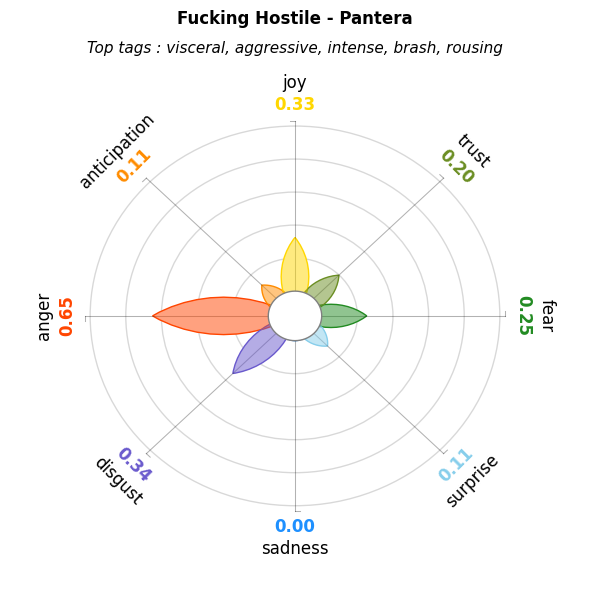

In [15]:
# Retrieve the emotion vector for a specific track, along with the top 10 tags
# 👉  Please feel free to re-run that cell to get a new random track

row_idx = random.randint(0, metadata.shape[0]-1)
data = metadata.iloc[row_idx, :]

# ---- Retrieve metadata ----
spotify_id = data["spotify_id"]
track_name, artist = data["name"], data["artist"]

# ---- Retrieve tags and occurences ----
tags_df = tags[tags['spotify_id'] == spotify_id].sort_values(by="normalized_count", ascending=False).drop_duplicates()
tags_df = tags_df[tags_df['selected']==1].head(10)
tags_list, counts = tags_df['tag'].tolist(), tags_df['count'].tolist()

header = f"Top {min(len(tags_list), 10)} tags and emotion vector for '{track_name}' by '{artist}'"
print(f"{header}\n{len(header)*'='}")

for t, c in zip(tags_list, counts):
    print(f"- {t} ({c})")

# ---- Retrieve final emotion vector ----
df = emotions[emotions['spotify_id'] == spotify_id]
vector_str = df['emotion_vector'].item().split(" ")
vector = np.array([float(val) for val in vector_str])

# ---- Visualize emotions (with tags ordered by occurency) and audio ----
plutchik_wheel(track_name, artist, vector, tags_list)
get_audio_link(f'{track_name} {artist}')